In [1]:
import os
import numpy as np
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization, Lambda, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Add
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers

Using TensorFlow backend.


# Modeling

### Load NumPy Arrays & convert labels

In [2]:
segs = 512

In [3]:
# Load compressed NumPy arrays
with np.load('orpheusC' + str(segs) + '.npz') as data:
    X_Train = data['Xp_Train']
    X_Val = data['Xp_Val']
    X_Test = data['Xp_Test']
    Y_Train = data['Y_Train']
    Y_Val  = data['Y_Val']
    Y_Test = data['Y_Test']

In [4]:
# Convert string labels to integers
le = preprocessing.LabelEncoder()
Y_Train = le.fit_transform(Y_Train)
Y_Val = le.fit_transform(Y_Val)
Y_Test = le.fit_transform(Y_Test)
le.classes_

array(['Blues', 'Classical', 'Country', 'Hip-Hop', 'Jazz', 'Metal', 'Pop',
       'Rock'], dtype='<U9')

In [5]:
# Confirm sample balance
import pandas as pd
Y_Traindf = pd.DataFrame(le.inverse_transform(Y_Train))
Y_Valdf = pd.DataFrame(le.inverse_transform(Y_Val))
Y_Testdf = pd.DataFrame(le.inverse_transform(Y_Test))
Y_Traindf[0].value_counts(),Y_Valdf[0].value_counts(),Y_Testdf[0].value_counts()

(Rock         880
 Pop          880
 Hip-Hop      880
 Classical    880
 Country      880
 Blues        880
 Jazz         880
 Metal        880
 Name: 0, dtype: int64,
 Classical    110
 Country      110
 Pop          110
 Rock         110
 Metal        110
 Jazz         110
 Hip-Hop      110
 Blues        110
 Name: 0, dtype: int64,
 Classical    110
 Country      110
 Pop          110
 Rock         110
 Metal        110
 Jazz         110
 Hip-Hop      110
 Blues        110
 Name: 0, dtype: int64)

### Build Model(s)

In [6]:
# Specifying input shape for first layer
input_shape = (segs, 12)

#### CNN (Pitch)

In [7]:
# Set dropout rate
dr = 0.25

In [8]:
# Build model using Sequential API
model = Sequential()

# 3x 1D Convolution layers
model.add(Conv1D(48, 5, activation='relu', input_shape=input_shape, data_format='channels_last'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=dr))

model.add(Conv1D(64, 5, activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=dr))

model.add(Conv1D(64, 5, activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=dr))

model.add(Flatten()) 
model.add(Dropout(rate=dr))

# 3 Dense Layers with ReLU activation
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer
model.add(Dense(8, activation='softmax'))

mtype = 'cnn'

### Compile Model

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Train Model

In [11]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, min_delta=0.01, patience=8)

In [12]:
# iterating 30 times on the data in batches of 32 samples then saving training history
hist = model.fit(X_Train, Y_Train, epochs=75, batch_size=32, validation_data=(X_Val, Y_Val), callbacks=[es])


Train on 7040 samples, validate on 880 samples
Epoch 1/75
7040/7040 [==============================] - 32s 5ms/step - loss: 1.9983 - accuracy: 0.1807 - val_loss: 1.8583 - val_accuracy: 0.2750
Epoch 2/75
7040/7040 [==============================] - 27s 4ms/step - loss: 1.7612 - accuracy: 0.2920 - val_loss: 1.7542 - val_accuracy: 0.3307
Epoch 3/75
7040/7040 [==============================] - 27s 4ms/step - loss: 1.6475 - accuracy: 0.3375 - val_loss: 1.5788 - val_accuracy: 0.3898
Epoch 4/75
7040/7040 [==============================] - 27s 4ms/step - loss: 1.4799 - accuracy: 0.4341 - val_loss: 1.2814 - val_accuracy: 0.5148
Epoch 5/75
7040/7040 [==============================] - 27s 4ms/step - loss: 1.3238 - accuracy: 0.4939 - val_loss: 1.2511 - val_accuracy: 0.5386
Epoch 6/75
7040/7040 [==============================] - 27s 4ms/step - loss: 1.2641 - accuracy: 0.5212 - val_loss: 1.2092 - val_accuracy: 0.5455
Epoch 7/75
7040/7040 [==============================] - 26s 4ms/step - loss: 1.225

In [13]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 508, 48)           2928      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 254, 48)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 254, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 254, 64)           15424     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 127, 64)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 127, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 127, 64)          

In [14]:
model.save(os.getcwd() + '/models/pitch/' + mtype + str(segs) + '_' + str(round(model.evaluate(X_Test, Y_Test)[1], 3)) + '.h5')

880/880 [==============================] - 1s 1ms/step


# Model Evaluation

### Plotting training and validation loss

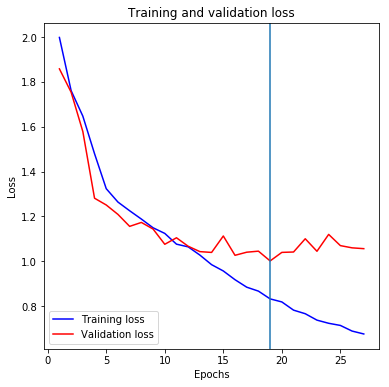

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.axvline(x = (np.argmin(val_loss)+1))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting training and validation accuracy

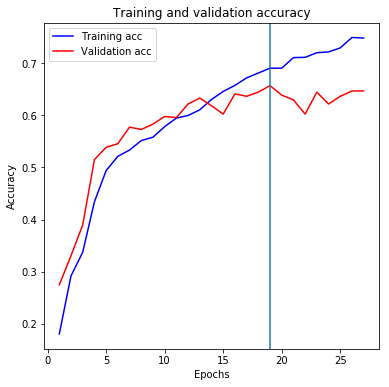

In [16]:
plt.figure(figsize=(6,6))
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.axvline(x = (np.argmax(val_acc)+1))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Epoch with highest validation accucary
np.argmax(val_acc)+1, val_acc[np.argmax(val_acc)]

(19, 0.6568182110786438)

In [18]:
results = model.evaluate(X_Test, Y_Test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

880/880 [==============================] - 1s 851us/step
Test loss: 1.1247541145844893
Test accuracy: 0.6261363625526428


### Accuracy per Genre

In [20]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_Test)
y_pred = np.argmax(y_pred, axis=1)
print(confusion_matrix(Y_Test, y_pred))

[[68  2 11  1  7  7  3 11]
 [ 4 96  2  1  4  0  0  3]
 [24  0 63  0  0  1  6 16]
 [ 1  1  6 71  2 11 15  3]
 [22  9  3  7 60  2  4  3]
 [ 8  1  0  0  1 86  4 10]
 [ 7  1  8 14  1  3 69  7]
 [18  5 14  2  0 23 10 38]]


Text(258.72, 0.5, 'Prediction')

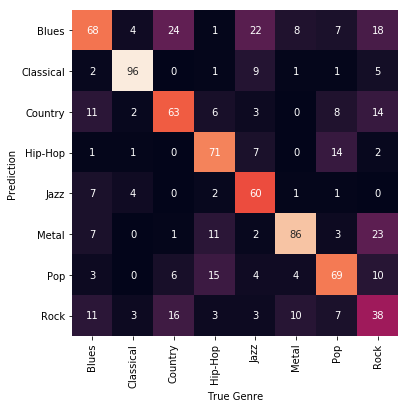

In [21]:
# Visualizing confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(12,6))
cm = confusion_matrix(Y_Test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_))
plt.xlabel('True Genre')
plt.ylabel('Prediction')

In [22]:
from sklearn.metrics import classification_report

print(Y_Test.shape, y_pred.shape)
print(classification_report(Y_Test, y_pred, target_names=list(le.classes_)))

(880,) (880,)
              precision    recall  f1-score   support

       Blues       0.45      0.62      0.52       110
   Classical       0.83      0.87      0.85       110
     Country       0.59      0.57      0.58       110
     Hip-Hop       0.74      0.65      0.69       110
        Jazz       0.80      0.55      0.65       110
       Metal       0.65      0.78      0.71       110
         Pop       0.62      0.63      0.62       110
        Rock       0.42      0.35      0.38       110

    accuracy                           0.63       880
   macro avg       0.64      0.63      0.63       880
weighted avg       0.64      0.63      0.63       880



In [23]:
# Create pandas df from classification report
report = classification_report(Y_Test, y_pred, target_names=list(le.classes_), output_dict=True)
reportdf = pd.DataFrame(report)
reportdf.T

,precision,recall,f1-score,support
Blues,0.447368,0.618182,0.519084,110.000000
Classical,0.834783,0.872727,0.853333,110.000000
Country,0.588785,0.572727,0.580645,110.000000
Hip-Hop,0.739583,0.645455,0.689320,110.000000
Jazz,0.800000,0.545455,0.648649,110.000000
Metal,0.646617,0.781818,0.707819,110.000000
Pop,0.621622,0.627273,0.624434,110.000000
Rock,0.417582,0.345455,0.378109,110.000000
accuracy,0.626136,0.626136,0.626136,0.626136
macro avg,0.637042,0.626136,0.625174,880.000000


In [24]:
# Export to latex
reportdf.to_latex('Class_Report_Pitch_' + mtype + '.tex', float_format="%.3f")